In [20]:
import netket as nk
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import jax.random as random
from jax.random import PRNGKey, split, categorical
import jax.lax as lax
from jax.lax import scan
import jax.nn as nn
import time
from tqdm import tqdm
from functools import partial
import time
from math import ceil
import itertools
from RNNfunction import *
import numpy as np

def local_element_indices_2d(num_body, pauli_array, loc_array):
    '''

    Args:
        num_body: The length of each Pauli string.
        pauli_array: The corresponding Pauli string of the Hamiltonian term.
        Ex: [[3,1,1,1,1],....[3,1,1,1,1]]
        loc_array: The location that the Hamiltonian term acts on.
        Ex: [[1,1],[1, 2], [2, 1], [1, 0], [0 ,1]]....[[Ny-2,Nx-2], [Ny-2, Nx-1], [Ny-1, Nx-2], [Ny-2, Nx-3], [Ny-3, Nx-2]]

    Returns:
        xy_loc_arrays, yloc_arrays, zloc_arrays
        They are all dictionarys that: [pauli_z terms, pauli_x terms]: The location that the Hamiltonian term acts on.
        For example:
        zloc_bulk: {(4, 1): Array([[[1, 2], [2, 1], [1, 0], [0, 1]],...
        [[2, 3], [3, 2], [2, 1], [1, 2]]]}
     '''
    if pauli_array.shape[-1] != num_body:
        raise ValueError(f"Array has incorrect body of interactions {pauli_array.shape[-1]}. Expected body of interactions is {num_body}.")

    #Count the number of pauli_Z and pauli_X for each term in the Hamiltonian
    count_3s = jnp.sum(pauli_array == 3, axis = 1)
    count_1s = jnp.sum(pauli_array == 1, axis = 1)

    pauli_array_xz = {}
    xloc_arrays = {}
    zloc_arrays = {}
    yloc_arrays = {}
    xy_loc_arrays = {}

    for i in range(num_body+1):    #z_number
        for j in range (num_body+1-i):  #x_number
            mask = ((count_3s == i)&(count_1s == j))  #mask for the interaction with i pauli_Z and j pauli_X
            pauli_array_xz[i, j] = pauli_array[mask]

            mask_x = (pauli_array_xz[i, j] == 1)
            mask_y = (pauli_array_xz[i, j] == 2)
            mask_z = (pauli_array_xz[i, j] == 3)

            if mask_x.sum() != 0:
                xloc_arrays[i, j] = loc_array[mask][mask_x].reshape(-1, j, 2)
            elif mask_y.sum() != 0 or mask_z.sum() !=0:
                if mask_y.sum()!=0:
                    xloc_arrays[i, j] = jnp.array([[]]).reshape(pauli_array_xz[i ,j].shape[0], 0, 2).astype(int)
                else:
                    xloc_arrays[i, j] = jnp.array([[]]).reshape(pauli_array_xz[i, j].shape[0], 0, 2).astype(int)

            if mask_y.sum() !=0:
                yloc_arrays[i, j] = loc_array[mask][mask_y].reshape(-1, num_body-i-j, 2).astype(int)
            elif mask_x.sum() != 0 or mask_z.sum() !=0:
                if mask_x.sum()!=0:
                    yloc_arrays[i, j] = jnp.array([[]]).reshape(pauli_array_xz[i, j].shape[0], 0, 2).astype(int)
                else:
                    yloc_arrays[i, j] = jnp.array([[]]).reshape(pauli_array_xz[i, j].shape[0], 0, 2).astype(int)

            if mask_z.sum()!=0:
                zloc_arrays[i, j] = loc_array[mask][mask_z].reshape(-1, i, 2).astype(int)
            elif mask_x.sum() != 0 or mask_y.sum() !=0:
                if mask_y.sum()!=0:
                    zloc_arrays[i, j] = jnp.array([[]]).reshape(pauli_array_xz[i, j].shape[0], 0, 2).astype(int)
                else:
                    zloc_arrays[i, j] = jnp.array([[]]).reshape(pauli_array_xz[i, j].shape[0], 0, 2).astype(int)

    for ind in (xloc_arrays):
        xy_loc_arrays[ind] = jnp.concatenate((xloc_arrays[ind], yloc_arrays[ind]), axis=1).astype(int)
    return  xy_loc_arrays, yloc_arrays, zloc_arrays

@jax.jit
def total_samples_2d(sample, xyloc_arrays):
    def single_samples_2d(sample, xy_loc_array_element):
        return sample.at[xy_loc_array_element[:, 0], xy_loc_array_element[:, 1]].set((sample[xy_loc_array_element[:, 0], xy_loc_array_element[:, 1]] + 1) % 2)
    results = []
    vmap_single_samples_2d = vmap(single_samples_2d, (None, 0))
    for i in xyloc_arrays:
        xy_loc_arrays_elements = xyloc_arrays[i]
        tmp = vmap_single_samples_2d(sample, xy_loc_arrays_elements)
        results.append(tmp)
    # Concatenate all results along axis=0
    concatenated_result = jnp.concatenate(results, axis=0)
    return concatenated_result

@jax.jit
def new_coe_2d(sample, coe_array_off_diag, yloc, zloc):
    def ycoe(single_sample, yloc_arrays_element):
        return ((0-1j)**single_sample[yloc_arrays_element[:,0],yloc_arrays_element[:,1]]).prod()
    def zcoe(single_sample, zloc_arrays_element):
        return ((-1+0j)**single_sample[zloc_arrays_element[:,0], zloc_arrays_element[:,1]]).prod()

    tmp_y = []
    tmp_z = []
    vmap_ycoe = vmap(ycoe, (None, 0))
    vmap_zcoe = vmap(zcoe, (None, 0))

    for i in yloc:
        tmp_y.append(lax.cond(yloc[i].shape[1] != 0, lambda: vmap_ycoe(sample, yloc[i]), lambda: jnp.repeat(jnp.array([1. + 0j]), yloc[i].shape[0])))
    for i in zloc:
        tmp_z.append(lax.cond(zloc[i].shape[1] != 0, lambda: vmap_zcoe(sample, zloc[i]), lambda: jnp.repeat(jnp.array([1. + 0j]), zloc[i].shape[0])))
    coe_tmp_y = jnp.concatenate(tmp_y, axis = 0)
    coe_tmp_z = jnp.concatenate(tmp_z, axis = 0)

    return coe_tmp_y * coe_tmp_z * coe_array_off_diag
@jax.jit
def diag_coe(samples, zloc_bulk_diag, zloc_edge_diag, zloc_corner_diag, coe_bulk_diag, coe_edge_diag, coe_corner_diag):
    def scan_z(samples, z_array):
        return ((-1) ** samples[z_array[:, 0], z_array[:, 1]]).prod()
    vmap_scan_z = vmap(scan_z, (None, 0))
    coe_bulk = (vmap_scan_z(samples, zloc_bulk_diag)*coe_bulk_diag).sum() if zloc_bulk_diag.size!=0 else 0
    coe_edge = (vmap_scan_z(samples, zloc_edge_diag)*coe_edge_diag).sum() if zloc_edge_diag.size!=0 else 0
    coe_corner = (vmap_scan_z(samples, zloc_corner_diag)*coe_corner_diag).sum() if zloc_corner_diag.size!=0 else 0
    return coe_bulk+coe_edge+coe_corner
def location_pauli_label(loc_array_bulk, loc_array_edge, loc_array_corner, Ny, Nx):
    '''
    Args:
        loc_array_bulk, loc_array_edge, loc_array_corner: Each element is the "location" that the Hamiltonian term acts on.

    Returns:
        Three dictionaries that label the location of the Hamiltonian term.
    For example,
    1. (0, 1) [[0. 4.]]
    means that the Hamiltonian terms act on the 0th row and 1st column of the grid
    is the 4th element of the 0th term in the Hamiltonian.

    2. (1, 2) [[0. 1.]
              [1. 0.]
              [3. 4.]]
    means that the Hamiltonian terms act on the 1st row and 2nd column of the grid
    is the 1st, 0th, 4th element of the 0th, 1st, 3rd terms in the Hamiltonian.
    '''

    label_bulk = {}
    label_edge = {}
    label_corner = {}
    # yi, xi : the location to label how many operation is acted on
    # y , x : The location of the loc_array that we can use to access the location to label
    for yi in range (Ny):
        for xi in range(Nx):
            y = 0
            tmp = jnp.array([])
            for i in loc_array_bulk:
                x = 0
                for j in i:
                    if (j == jnp.array([yi, xi])).all():
                        tmp = jnp.append(tmp, jnp.array([y, x]))
                    x += 1
                y += 1
            label_bulk[yi, xi] = tmp.reshape(-1, 2)
    for yi in range (Ny):
        for xi in range(Nx):
            y = 0
            tmp = jnp.array([])
            for i in loc_array_edge:
                x = 0
                for j in i:
                    if (j == jnp.array([yi, xi])).all():
                        tmp = jnp.append(tmp, jnp.array([y, x]))
                    x += 1
                y += 1
            label_edge[yi, xi] = tmp.reshape(-1, 2)
    for yi in range (Ny):
        for xi in range(Nx):
            y = 0
            tmp = jnp.array([])
            for i in loc_array_corner:
                x = 0
                for j in i:
                    if (j == jnp.array([yi, xi])).all():
                        tmp = jnp.append(tmp, jnp.array([y, x]))
                    x += 1
                y += 1
            label_corner[yi, xi] = tmp.reshape(-1, 2)
    return label_bulk, label_edge, label_corner

def loc_array_gf(Ny, Nx):
    '''
    Inputs
    Ny, Nx : The size of the grid

    Outputs:
    The location that each Hamiltonian term acts on.
    Specifically,

    For loc_array bulk: it is [[[1, 1], [1, 2], [2, 1], [1, 0], [0 ,1]]....[[Ny-2,Nx-2], [Ny-2, Nx-1], [Ny-1, Nx-2], [Ny-2, Nx-3], [Ny-3, Nx-2]]
    For single element, the order inside is :
        4
    3   0   1
        2
    For the entire array, it follows that it moves right first until the boundary and then go to the first element of the next row.

    For loc_array corner: it is [[[0, 0],[0 ,1], [1, 0]]...[[Ny - 1, Nx - 1], [Ny - 1, Nx - 2], [Ny - 2, Nx - 1]]]
    For single element, the order inside follows that dealing with x-axis first and then y-axis.
    '''
    I, J = jnp.meshgrid(jnp.arange(1, Ny - 1), jnp.arange(1, Nx - 1), indexing='ij')
    bulk_coordinates = jnp.stack([I, J, I, J + 1, I + 1, J, I, J - 1, I - 1, J], axis=-1)
    loc_array_bulk = bulk_coordinates.reshape(-1, 5, 2)

    # Add edge coordinates excluding corners for the left and right sides of the grid
    edge_coordinates = []
    for i in range(1, Ny - 1):
        edge_coordinates.extend([[i, 0], [i, 1], [i + 1, 0], [i - 1, 0]])
        edge_coordinates.extend([[i, Nx - 1], [i, Nx - 2], [i + 1, Nx - 1], [i - 1, Nx - 1]])

    # Add edge coordinates excluding corners for the top and bottom of the grid
    for j in range(1, Nx - 1):
        edge_coordinates.extend([[0, j], [1, j], [0, j - 1], [0, j + 1]])
        edge_coordinates.extend([[Ny - 1, j], [Ny - 2, j], [Ny - 1, j - 1], [Ny - 1, j + 1]])

    # Convert list to a JAX array
    loc_array_edge = jnp.array(edge_coordinates).reshape(-1, 4, 2)

    loc_array_corner = jnp.array([[[0, 0], [0, 1], [1, 0]],
                                  [[0, Nx - 1], [0, Nx - 2], [1, Nx - 1]],
                                  [[Ny - 1, 0], [Ny - 1, 1], [Ny - 2, 0]],
                                  [[Ny - 1, Nx - 1], [Ny - 1, Nx - 2], [Ny - 2, Nx - 1]]])
    return loc_array_bulk, loc_array_edge, loc_array_corner
def pauli_cmi_pattern(pauli_array_bulk, pauli_array_edge, pauli_array_corner, label_bulk, label_edge, label_corner, cmi_pattern, key, sparsity, L):
    '''
    Input : pauli_array
    Output : pauli_array with the pattern(no_decay, decay, random or ordered_random)
    '''
    if (cmi_pattern == "no_decay"):
        print("Pattern: no_decay")
        for i in label_bulk:
            pauli_array_bulk = pauli_array_bulk.at[label_bulk[i][:,0].astype(int), label_bulk[i][:,1].astype(int)].set(pauli_array_bulk[label_bulk[i][:,0].astype(int), label_bulk[i][:,1].astype(int)])
        for i in label_edge:
            pauli_array_edge = pauli_array_edge.at[label_edge[i][:,0].astype(int), label_edge[i][:,1].astype(int)].set(pauli_array_edge[label_edge[i][:,0].astype(int), label_edge[i][:,1].astype(int)])
        for i in label_corner:
            pauli_array_corner = pauli_array_corner.at[label_corner[i][:,0].astype(int), label_corner[i][:,1].astype(int)].set(pauli_array_corner[label_corner[i][:,0].astype(int), label_corner[i][:,1].astype(int)])
    elif(cmi_pattern == "random"):
        print("Pattern:random")
        for i in label_bulk:
            key, subkey = split(key, 2)
            p = jax.random.uniform(subkey, jnp.array([1]), float, 0 , 1)
            if p>0.5:
                pauli_array_bulk = pauli_array_bulk.at[label_bulk[i][:,0].astype(int), label_bulk[i][:,1].astype(int)].set(pauli_array_bulk[label_bulk[i][:,0].astype(int), label_bulk[i][:,1].astype(int)])
                pauli_array_edge = pauli_array_edge.at[label_edge[i][:,0].astype(int), label_edge[i][:,1].astype(int)].set(pauli_array_edge[label_edge[i][:,0].astype(int), label_edge[i][:,1].astype(int)])
                pauli_array_corner = pauli_array_corner.at[label_corner[i][:,0].astype(int), label_corner[i][:,1].astype(int)].set(pauli_array_corner[label_corner[i][:,0].astype(int), label_corner[i][:,1].astype(int)])
    elif (cmi_pattern == "ordered_random"):
        print("Pattern:ordered_random")
        for i in label_bulk:
            if (i[0]%2 == 0):
                if ((i[0]*L+i[1]+1)%sparsity==0):
                    pauli_array_bulk = pauli_array_bulk.at[
                        label_bulk[i][:, 0].astype(int), label_bulk[i][:, 1].astype(int)].set(
                        pauli_array_bulk[label_bulk[i][:, 0].astype(int), label_bulk[i][:, 1].astype(int)])
                    pauli_array_edge = pauli_array_edge.at[
                        label_edge[i][:, 0].astype(int), label_edge[i][:, 1].astype(int)].set(
                        pauli_array_edge[label_edge[i][:, 0].astype(int), label_edge[i][:, 1].astype(int)])
                    pauli_array_corner = pauli_array_corner.at[
                        label_corner[i][:, 0].astype(int), label_corner[i][:, 1].astype(int)].set(
                        pauli_array_corner[label_corner[i][:, 0].astype(int), label_corner[i][:, 1].astype(int)])
            elif (i[0]%2 == 1):
                if (((i[0]+1)*L-i[1])%sparsity==0):
                    pauli_array_bulk = pauli_array_bulk.at[
                        label_bulk[i][:, 0].astype(int), label_bulk[i][:, 1].astype(int)].set(
                        pauli_array_bulk[label_bulk[i][:, 0].astype(int), label_bulk[i][:, 1].astype(int)])
                    pauli_array_edge = pauli_array_edge.at[
                        label_edge[i][:, 0].astype(int), label_edge[i][:, 1].astype(int)].set(
                        pauli_array_edge[label_edge[i][:, 0].astype(int), label_edge[i][:, 1].astype(int)])
                    pauli_array_corner = pauli_array_corner.at[
                        label_corner[i][:, 0].astype(int), label_corner[i][:, 1].astype(int)].set(
                        pauli_array_corner[label_corner[i][:, 0].astype(int), label_corner[i][:, 1].astype(int)])
    else:
        print("Pattern:decay")
    return pauli_array_bulk, pauli_array_edge, pauli_array_corner

def off_diag_count(xy_loc_bulk, xy_loc_edge, xy_loc_corner):
    off_diag_bulk_count, off_diag_edge_count, off_diag_corner_count = 0, 0, 0
    for i in xy_loc_bulk:
        if i[1] != 0:
            off_diag_bulk_count += xy_loc_bulk[i].shape[0]
        else:
            diag_bulk_count = 1
    for i in xy_loc_edge:
        if i[1] != 0:
            off_diag_edge_count += xy_loc_edge[i].shape[0]
        else:
            diag_edge_count = 1
    for i in xy_loc_corner:
        if i[1] != 0:
            off_diag_corner_count += xy_loc_corner[i].shape[0]
        else:
            diag_corner_count = 1
    return off_diag_bulk_count, off_diag_edge_count, off_diag_corner_count
import netket as nk
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import jax.random as random
from jax.random import PRNGKey, split, categorical
import jax.lax as lax
from jax.lax import scan
import jax.nn as nn
import time
from tqdm import tqdm
from functools import partial
import time
from math import ceil
import itertools
from RNNfunction import *
import numpy as np

def generate_combinations(length):
    set1 = [1] * length
    set2 = [3] * length
    combinations = list(itertools.product(*zip(set1, set2)))
    return jnp.array(combinations)


def all_coe(array, x, y):
    # Function to calculate x^n * y^m for a single element
    def calculate_product(element):
        n = jnp.sum(element == 1)  # Count of 1s
        m = jnp.sum(element == 3)  # Count of 3s
        return x ** n * y ** m

    coe = jnp.apply_along_axis(calculate_product, 1, array)
    return coe


def linear_cycling_with_hold(schedule_step, max_lr, min_lr, cycle_steps):
    if schedule_step <= 8 * cycle_steps:
        cycle = jnp.floor(1 + schedule_step / (2 * cycle_steps))
        x = jnp.abs(schedule_step / cycle_steps - 2 * cycle + 1)
        lr = min_lr + (max_lr - min_lr) * jnp.maximum(0, (1 - x))
    else:
        lr = 2 * min_lr
    return lr


@partial(jax.jit, static_argnames=['fixed_parameters'])
def compute_cost(parameters, fixed_parameters, samples, Eloc, Temperature):
    samples = jax.lax.stop_gradient(samples)
    Eloc = jax.lax.stop_gradient(Eloc)

    # First term

    log_amps_tensor = log_amp(samples, parameters, fixed_parameters)
    term1 = 2 * jnp.real(jnp.mean(log_amps_tensor.conjugate() * (Eloc - jnp.mean(Eloc))))
    # Second term

    term2 = 4 * Temperature * (jnp.mean(jnp.real(log_amps_tensor) * jax.lax.stop_gradient(jnp.real(log_amps_tensor)))
                               - jnp.mean(jnp.real(log_amps_tensor)) * jnp.mean(
                jax.lax.stop_gradient(jnp.real(log_amps_tensor))))

    cost = term1 + term2

    return cost

def clip_grad(g, clip_norm=10.0):
    norm = jnp.linalg.norm(g)
    scale = jnp.minimum(1.0, clip_norm / (norm + 1e-6))
    return g * scale

def schedule(step: float, min_lr: float, max_lr: float, period: float) -> float:
    """Compute a learning rate that oscillates sinusoidally between min_lr and max_lr."""
    oscillation = (jnp.sin(jnp.pi * step / period) + 1) / 2  # Will be between 0 and 1
    return min_lr + (max_lr - min_lr) * oscillation

In [33]:
Ny, Nx = 4, 4
angle = 0.
pauli_array_bulk, pauli_array_edge, pauli_array_corner = jnp.repeat(generate_combinations(5), (Ny-2)*(Nx-2), axis=0), jnp.repeat(generate_combinations(4),(Ny+Nx-4)*2, axis=0), jnp.repeat(generate_combinations(3), 4, axis=0)
x, y = jnp.cos(angle), jnp.sin(angle)
pauli_array_bulk_coe, pauli_array_edge_coe, pauli_array_corner_coe = all_coe(pauli_array_bulk, x, y), all_coe(pauli_array_edge, x, y), all_coe(pauli_array_corner, x, y)
loc_array_bulk, loc_array_edge, loc_array_corner = loc_array_gf(Ny, Nx)

loc_array_bulk = jnp.repeat(loc_array_bulk, 32, axis=0)
loc_array_edge = jnp.repeat(loc_array_edge, 16, axis=0)
loc_array_corner = jnp.repeat(loc_array_corner, 8, axis=0)

In [32]:
xy_loc_bulk, yloc_bulk, zloc_bulk = local_element_indices_2d(5, pauli_array_bulk, loc_array_bulk)
xy_loc_edge, yloc_edge, zloc_edge = local_element_indices_2d(4, pauli_array_edge, loc_array_edge)
xy_loc_corner, yloc_corner, zloc_corner = local_element_indices_2d(3, pauli_array_corner, loc_array_corner)


IndexError: boolean index did not match shape of indexed array in index 0: got (128,), expected (4,)

In [28]:
def all_coe(array, x, y):
    # Function to calculate x^n * y^m for a single element
    def calculate_product(element):
        n = jnp.sum(element == 1)  # Count of 1s
        m = jnp.sum(element == 3)  # Count of 3s
        return x ** n * y ** m
    comb_num = 2**(array.shape[1])
    coe = jnp.apply_along_axis(calculate_product, 1, array)[:-comb_num+1]
    return coe


{(0,
  3): Array([[[0, 0],
         [0, 1],
         [1, 0]],
 
        [[0, 0],
         [0, 1],
         [1, 0]],
 
        [[0, 0],
         [0, 1],
         [1, 0]],
 
        [[0, 0],
         [0, 1],
         [1, 0]]], dtype=int32),
 (1,
  2): Array([[[0, 0],
         [0, 1]],
 
        [[0, 0],
         [0, 1]],
 
        [[0, 0],
         [0, 1]],
 
        [[0, 0],
         [0, 1]],
 
        [[0, 3],
         [1, 3]],
 
        [[0, 3],
         [1, 3]],
 
        [[0, 3],
         [1, 3]],
 
        [[0, 3],
         [1, 3]],
 
        [[3, 1],
         [2, 0]],
 
        [[3, 1],
         [2, 0]],
 
        [[3, 1],
         [2, 0]],
 
        [[3, 1],
         [2, 0]]], dtype=int32),
 (2,
  1): Array([[[0, 3]],
 
        [[0, 3]],
 
        [[0, 3]],
 
        [[0, 3]],
 
        [[3, 1]],
 
        [[3, 1]],
 
        [[3, 1]],
 
        [[3, 1]],
 
        [[2, 3]],
 
        [[2, 3]],
 
        [[2, 3]],
 
        [[2, 3]]], dtype=int32),
 (3, 0): Array([], dtype=int32)

In [36]:
array1 = jnp.array([[True, False, True],[True, True, True]])
array2 = jnp.array([True, True, False])
array1 == array2

Array([[ True, False, False],
       [ True,  True, False]], dtype=bool)

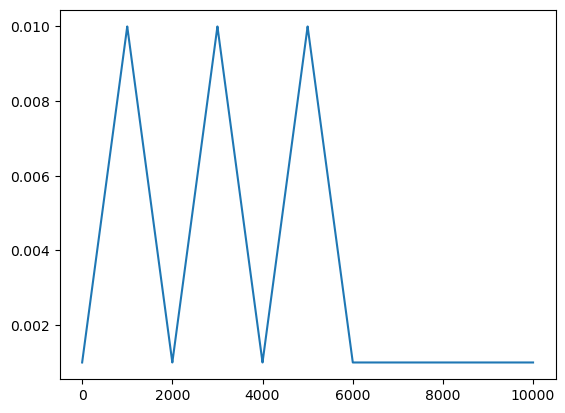

In [9]:

for i in range (10000):
    lr.append(scheduler(i))
import matplotlib.pyplot as plt
plt.plot(lr)

In [7]:
from functools import partial
import jax
import jax.numpy as jnp

def local_element_indices_2d(num_body, pauli_array, loc_array):
    if pauli_array.shape[-1] != num_body:
        raise ValueError(f"Array has incorrect body of interactions {pauli_array.shape[-1]}. Expected body of interactions is {num_body}.")

    count_3s = jnp.sum(pauli_array == 3, axis = 1)
    count_1s = jnp.sum(pauli_array == 1, axis = 1)

    pauli_array_xz = {}
    xloc_arrays = {}
    zloc_arrays = {}
    yloc_arrays = {}
    xy_loc_arrays = {}

    for i in range(num_body+1):    #z_number
        for j in range (num_body+1-i):  #x_number
            mask = ((count_3s == i)&(count_1s == j))
            pauli_array_xz[i, j] = pauli_array[mask]

            mask_x = (pauli_array_xz[i, j] == 1)
            mask_y = (pauli_array_xz[i, j] == 2)
            mask_z = (pauli_array_xz[i, j] == 3)

            if mask_x.sum() != 0:
                xloc_arrays[i, j] = loc_array[mask][mask_x].reshape(-1, j, 2)
            elif mask_y.sum() != 0 or mask_z.sum() !=0:
                if mask_y.sum()!=0:
                    xloc_arrays[i, j] = jnp.array([[]]).reshape(pauli_array_xz[i ,j].shape[0], 0, 2).astype(int)
                else:
                    xloc_arrays[i, j] = jnp.array([[]]).reshape(pauli_array_xz[i, j].shape[0], 0, 2).astype(int)

            if mask_y.sum() !=0:
                yloc_arrays[i, j] = loc_array[mask][mask_y].reshape(-1, num_body-i-j, 2).astype(int)
            elif mask_x.sum() != 0 or mask_z.sum() !=0:
                if mask_x.sum()!=0:
                    yloc_arrays[i, j] = jnp.array([[]]).reshape(pauli_array_xz[i, j].shape[0], 0, 2).astype(int)
                else:
                    yloc_arrays[i, j] = jnp.array([[]]).reshape(pauli_array_xz[i, j].shape[0], 0, 2).astype(int)

            if mask_z.sum()!=0:
                zloc_arrays[i, j] = loc_array[mask][mask_z].reshape(-1, i, 2).astype(int)
            elif mask_x.sum() != 0 or mask_y.sum() !=0:
                if mask_y.sum()!=0:
                    zloc_arrays[i, j] = jnp.array([[]]).reshape(pauli_array_xz[i, j].shape[0], 0, 2).astype(int)
                else:
                    zloc_arrays[i, j] = jnp.array([[]]).reshape(pauli_array_xz[i, j].shape[0], 0, 2).astype(int)
    print("xlco_arrays:", xloc_arrays)
    print("yloc_arrays:", yloc_arrays)
    for ind in (xloc_arrays):
        xy_loc_arrays[ind] = jnp.concatenate((xloc_arrays[ind], yloc_arrays[ind]), axis=1).astype(int)
    return  xy_loc_arrays, yloc_arrays, zloc_arrays
@jax.jit
def total_samples_2d(samples, xyloc):
    def scan_array_element(sample_element, xyloc_arrays_element):
        scan_samples = sample_element.at[xyloc_arrays_element[:,0], xyloc_arrays_element[:,1]].set((sample_element[xyloc_arrays_element[:,0], xyloc_arrays_element[:,1]]+1)%2)
        return sample_element, scan_samples
    sample_tmp = samples
    for xyloc_ind in xyloc:
        if xyloc[xyloc_ind].size != 0:
            sample_tmp = jnp.append(sample_tmp, jax.lax.scan(scan_array_element, samples, xyloc[xyloc_ind])[1])
    print(xyloc[xyloc_ind])
    return sample_tmp.reshape(-1, samples.shape[0], samples.shape[1])

@jax.jit
def new_coe_2d(samples, coe_array, yloc, zloc):
    def ycoe(sample_element, yloc_arrays_element):
        scan_coe_tmp_y = ((-1)**sample_element[yloc_arrays_element[:,0],yloc_arrays_element[:,1]]*1j).prod()
        return sample_element, scan_coe_tmp_y
    def zcoe(sample_element, zloc_arrays_element):
        scan_coe_tmp_z = ((-1)**sample_element[zloc_arrays_element[:,0], zloc_arrays_element[:,1]]).prod()
        return sample_element, scan_coe_tmp_z
    coe_tmp_y = jnp.array([1])
    coe_tmp_z = jnp.array([1])
    for yloc_ind in yloc:
        if yloc[yloc_ind].shape[0] != 0:
            coe_tmp_y = jnp.append(coe_tmp_y, jax.lax.scan(ycoe, samples, yloc[yloc_ind])[1])
        else:
            coe_tmp_y = jnp.append(coe_tmp_y, 1)
    for zloc_ind in zloc:
        if zloc_ind[1] == 0:
            coe_tmp_z = coe_tmp_z.at([0]).set(jax.lax.scan(zcoe, samples, zloc[zloc_ind])[1].sum())
        elif zloc[zloc_ind].shape[0] != 0:
            coe_tmp_z = jnp.append(coe_tmp_z, jax.lax.scan(zcoe, samples, zloc[zloc_ind])[1])
        else:
            coe_tmp_z = jnp.append(coe_tmp_z, 1)
    return coe_tmp_y*coe_tmp_z*jnp.concatenate((jnp.array([1]), coe_array), axis=0)

In [8]:
from jax import random
from jax.random import PRNGKey, randint
import numpy as np
pauli_array = jnp.repeat(jnp.array([1,3,3,3,3])[None], 16, axis = 0).astype(int)
print("pauli_array:", pauli_array)
loc_array = jnp.array([[]])
for i in range (1, 5):
    for j in range (1, 5):
        loc_array = jnp.append(loc_array, jnp.array([[i,j],[i,j+1],[i+1,j],[i-1,j], [i, j-1]]))
loc_array = loc_array.reshape(16, 5, 2)
print("loc_array:", loc_array)
xy_loc, yloc, zloc = local_element_indices_2d(5, pauli_array, loc_array)
print("zloc:", zloc)

pauli_array: [[1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]]
loc_array: [[[1. 1.]
  [1. 2.]
  [2. 1.]
  [0. 1.]
  [1. 0.]]

 [[1. 2.]
  [1. 3.]
  [2. 2.]
  [0. 2.]
  [1. 1.]]

 [[1. 3.]
  [1. 4.]
  [2. 3.]
  [0. 3.]
  [1. 2.]]

 [[1. 4.]
  [1. 5.]
  [2. 4.]
  [0. 4.]
  [1. 3.]]

 [[2. 1.]
  [2. 2.]
  [3. 1.]
  [1. 1.]
  [2. 0.]]

 [[2. 2.]
  [2. 3.]
  [3. 2.]
  [1. 2.]
  [2. 1.]]

 [[2. 3.]
  [2. 4.]
  [3. 3.]
  [1. 3.]
  [2. 2.]]

 [[2. 4.]
  [2. 5.]
  [3. 4.]
  [1. 4.]
  [2. 3.]]

 [[3. 1.]
  [3. 2.]
  [4. 1.]
  [2. 1.]
  [3. 0.]]

 [[3. 2.]
  [3. 3.]
  [4. 2.]
  [2. 2.]
  [3. 1.]]

 [[3. 3.]
  [3. 4.]
  [4. 3.]
  [2. 3.]
  [3. 2.]]

 [[3. 4.]
  [3. 5.]
  [4. 4.]
  [2. 4.]
  [3. 3.]]

 [[4. 1.]
  [4. 2.]
  [5. 1.]
  [3. 1.]
  [4. 0.]]

 [[4. 2.]
  [4. 3.]
  [5. 2.]
  [3. 2.]
  [4. 1.]]

 [[4. 3.]
  [4. 4.]
  [5. 3.]
  [3. 3.]

In [7]:
import jax.numpy as jnp

Ny, Nx = 4, 4  # Define Ny and Nx with assumed values for demonstration

# Pre-allocate bulk locations with array operations
I, J = jnp.meshgrid(jnp.arange(1, Ny-1), jnp.arange(1, Nx-1), indexing='ij')
bulk_coordinates = jnp.stack([I, J, I, J+1, I+1, J, I-1, J, I, J-1], axis=-1)
loc_array_bulk = bulk_coordinates.reshape(-1, 5, 2)

# Create edges excluding corners
edge_top = jnp.stack([jnp.ones(Nx-2), jnp.arange(1, Nx-1)], axis=-1)
edge_bottom = jnp.stack([jnp.full((Nx-2,), Ny-1), jnp.arange(1, Nx-1)], axis=-1)
edge_left = jnp.stack([jnp.arange(1, Ny-1), jnp.zeros(Ny-2)], axis=-1)
edge_right = jnp.stack([jnp.arange(1, Ny-1), jnp.full((Ny-2,), Nx-1)], axis=-1)
edges = jnp.concatenate([edge_top, edge_bottom, edge_left, edge_right])
loc_array_edge = jnp.repeat(edges[:, None, :], 4, axis=1) # Repeat the edge pattern

# Fix the edge coordinates with appropriate values
loc_array_edge = loc_array_edge.at[:, 1:, 0].add(1)  # Increment i or j based on direction
loc_array_edge = loc_array_edge.at[:, 2, 1].set(0)    # Set j=0 for left edge increments
loc_array_edge = loc_array_edge.at[:, 3, 0].set(Ny-1) # Set i=Ny-1 for bottom edge increments
loc_array_edge = loc_array_edge.reshape(-1, 4, 2)

# Pre-defined corner locations
loc_array_corner = jnp.array([[[0,0],[0,1],[1,0]],
                              [[0, Nx-1],[0, Nx-2], [1, Nx-1]],
                              [[Ny-1, 0],[Ny-1, 1],[Ny-2,0]],
                              [[Ny-1, Nx-1],[Ny-1, Nx-2],[Ny-2, Nx-1]]])

# Pauli arrays can be created directly since their pattern doesn't depend on Ny or Nx
pauli_array_bulk = jnp.tile(jnp.array([[1,3,3,3,3]]), ((Ny-2)*(Nx-2), 1))
pauli_array_edge = jnp.tile(jnp.array([[1,3,3,3]]), ((Ny+Nx-4)*2, 1))
pauli_array_corner = jnp.tile(jnp.array([[1,3,3]]), (4, 1))

# It's assumed local_element_indices_2d function exists and operates on the inputs provided
# xy_loc_bulk, yloc_bulk, zloc_bulk = local_element_indices_2d(5, pauli_array_bulk, loc_array_bulk)
# xy_loc_edge, yloc_edge, zloc_edge = local_element_indices_2d(4, pauli_array_edge, loc_array_edge)
# xy_loc_corner, yloc_corner, zloc_corner = local_element_indices_2d(3, pauli_array_corner, loc_array_corner)


In [94]:
jnp.meshgrid(jnp.arange(1, Ny-1), jnp.arange(1, Nx-1), indexing='ij')

[Array([[1, 1],
        [2, 2]], dtype=int32),
 Array([[1, 2],
        [1, 2]], dtype=int32)]

In [97]:
# Add edge coordinates excluding corners for the left and right sides of the grid
edge_coordinates = []
for i in range(1, Ny - 1):
    edge_coordinates.extend([[i, 0], [i, 1], [i + 1, 0], [i - 1, 0]])
    edge_coordinates.extend([[i, Nx - 1], [i, Nx - 2], [i + 1, Nx - 1], [i - 1, Nx - 1]])

# Add edge coordinates excluding corners for the top and bottom of the grid
for j in range(1, Nx - 1):
    edge_coordinates.extend([[0, j], [1, j], [0, j - 1], [0, j + 1]])
    edge_coordinates.extend([[Ny - 1, j], [Ny - 2, j], [Ny - 1, j - 1], [Ny - 1, j + 1]])

# Convert list to a JAX array
loc_array_edge = jnp.array(edge_coordinates).reshape(-1, 4, 2)

In [128]:
import jax
import jax.numpy as jnp
from jax import random

def create_variables(name, num_units, num_in, dtype):
    key = random.PRNGKey(0)  # You should pass a PRNGKey as an argument for reproducibility

    # JAX uses glorot_uniform as the default which is a fan_avg uniform distribution.
    # It's equivalent to TensorFlow's VarianceScaling with scale=1.0, mode='fan_avg', distribution='uniform'.
    glorot_init = jax.nn.initializers.variance_scaling(1.0, "average", "uniform")

    # Create variables
    W_shape = (num_units, 2 * num_units, 2 * num_in)
    b_shape = (num_units,)
    Wg_shape = (num_units, 2 * num_units, 2 * num_in)
    bg_shape = (num_units,)
    Wmerge_shape = (2 * num_units, num_units)

    # Split key for each variable
    W_key, b_key, Wg_key, bg_key, Wmerge_key = random.split(key, 5)

    W = glorot_init(W_key, W_shape, dtype)
    b = glorot_init(b_key, b_shape, dtype)
    Wg = glorot_init(Wg_key, Wg_shape, dtype)
    bg = glorot_init(bg_key, bg_shape, dtype)
    Wmerge = glorot_init(Wmerge_key, Wmerge_shape, dtype)

    return {"W_" + name: W, "b_" + name: b, "Wg_" + name: Wg, "bg_" + name: bg, "Wmerge_" + name: Wmerge}

# Use the function to create variables
variables = create_variables('example', num_units=512, num_in=256, dtype=jnp.float32)

# Access variables like this:
W = variables["W_example"]
b = variables["b_example"]
Wg = variables["Wg_example"]
bg = variables["bg_example"]
Wmerge = variables["Wmerge_example"]


ValueError: invalid mode for variance scaling initializer: average

In [2]:
import jax
import jax.numpy as jnp
import jax.lax as lax
lax.cond(0., lambda x: x+1, lambda x: x+2, 2)

Array(4, dtype=int32, weak_type=True)

In [9]:
def location_pauli_label(loc_array_bulk, loc_array_edge, loc_array_corner):
    label_bulk = {}
    label_edge = {}
    label_corner = {}
    # yi, xi : the location to label how many operation is acted on
    # y , x : The location of the loc_array that we can use to access the location to label
    for yi in range (4):
        for xi in range(4):
            y = 0
            tmp = jnp.array([])
            for i in loc_array_bulk:
                x = 0
                for j in i:
                    if (j == jnp.array([yi, xi])).all():
                        tmp = jnp.append(tmp, jnp.array([y, x]))
                    x += 1
                y += 1
            label_bulk[yi, xi] = tmp.reshape(-1, 2)
    for yi in range (4):
        for xi in range(4):
            y = 0
            tmp = jnp.array([])
            for i in loc_array_edge:
                x = 0
                for j in i:
                    if (j == jnp.array([yi, xi])).all():
                        tmp = jnp.append(tmp, jnp.array([y, x]))
                    x += 1
                y += 1
            label_edge[yi, xi] = tmp.reshape(-1, 2)
    for yi in range (4):
        for xi in range(4):
            y = 0
            tmp = jnp.array([])
            for i in loc_array_corner:
                x = 0
                for j in i:
                    if (j == jnp.array([yi, xi])).all():
                        tmp = jnp.append(tmp, jnp.array([y, x]))
                    x += 1
                y += 1
            label_corner[yi, xi] = tmp.reshape(-1, 2)
    return label_bulk, label_edge, label_corner

In [21]:
label_bulk, label_edge, label_corner = location_pauli_label(loc_array_bulk, loc_array_edge, loc_array_corner)
pauli_array_bulk, pauli_array_edge, pauli_array_corner  = jnp.repeat(jnp.array([1,3,3,3,3])[None], (Ny-2)*(Nx-2), axis=0), jnp.repeat(jnp.array([1,3,3,3])[None], (Ny+Nx-4)*2, axis=0), jnp.repeat(jnp.array([1,3,3])[None], 4, axis=0)


In [55]:
pauli_array_bulk

Array([[1, 1, 1, 1, 1],
       [3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3],
       [1, 1, 1, 1, 1]], dtype=int32)

In [56]:
pauli_array_bulk = jnp.repeat(jnp.array([1,3,3,3,3])[None], (Ny-2)*(Nx-2), axis=0)
pauli_array_edge = jnp.repeat(jnp.array([1,3,3,3])[None], (Ny+Nx-4)*2, axis=0)
pauli_array_corner = jnp.repeat(jnp.array([1,3,3])[None], 4, axis=0)
# The location that each Hamiltonian term acts on
loc_array_bulk, loc_array_edge, loc_array_corner = loc_array(4, 4)
# We group the location that each Hamiltonian term acts on according to how many x,y,z they have in each term
xy_loc_bulk, yloc_bulk, zloc_bulk = local_element_indices_2d(5, pauli_array_bulk, loc_array_bulk)
xy_loc_edge, yloc_edge, zloc_edge = local_element_indices_2d(4, pauli_array_edge, loc_array_edge)
xy_loc_corner, yloc_corner, zloc_corner = local_element_indices_2d(3, pauli_array_corner, loc_array_corner)
# label_xxx[y, x] is a dict datatype and it is the location of loc_array_xxx such that pauli_array_bulk.at[label[i][:,0].astype(int), label[i][:,1].astype(int)] will
# show the pauli matrix that acts on lattice location
label_bulk, label_edge, label_corner = location_pauli_label(loc_array_bulk, loc_array_edge, loc_array_corner)
for i in label_bulk:
    pauli_array_bulk = pauli_array_bulk.at[label_bulk[i][:,0].astype(int), label_bulk[i][:,1].astype(int)].set(-pauli_array_bulk[label_bulk[i][:,0].astype(int), label_bulk[i][:,1].astype(int)]+4)
for i in label_edge:
    pauli_array_edge = pauli_array_edge.at[label_edge[i][:,0].astype(int), label_edge[i][:,1].astype(int)].set(-pauli_array_edge[label_edge[i][:,0].astype(int), label_edge[i][:,1].astype(int)]+4)
for i in label_corner:
    pauli_array_corner = pauli_array_corner.at[label_corner[i][:,0].astype(int), label_corner[i][:,1].astype(int)].set(-pauli_array_corner[label_corner[i][:,0].astype(int), label_corner[i][:,1].astype(int)]+4)


TypeError: 'ArrayImpl' object is not callable

In [27]:
pauli_array_corner

Array([[3, 1, 1],
       [3, 1, 1],
       [3, 1, 1],
       [3, 1, 1]], dtype=int32)

In [19]:
def loc_array(Ny, Nx):
    I, J = jnp.meshgrid(jnp.arange(1, Ny - 1), jnp.arange(1, Nx - 1), indexing='ij')
    bulk_coordinates = jnp.stack([I, J, I, J + 1, I + 1, J, I - 1, J, I, J - 1], axis=-1)
    loc_array_bulk = bulk_coordinates.reshape(-1, 5, 2)

    # Add edge coordinates excluding corners for the left and right sides of the grid
    edge_coordinates = []
    for i in range(1, Ny - 1):
        edge_coordinates.extend([[i, 0], [i, 1], [i + 1, 0], [i - 1, 0]])
        edge_coordinates.extend([[i, Nx - 1], [i, Nx - 2], [i + 1, Nx - 1], [i - 1, Nx - 1]])

    # Add edge coordinates excluding corners for the top and bottom of the grid
    for j in range(1, Nx - 1):
        edge_coordinates.extend([[0, j], [1, j], [0, j - 1], [0, j + 1]])
        edge_coordinates.extend([[Ny - 1, j], [Ny - 2, j], [Ny - 1, j - 1], [Ny - 1, j + 1]])

    # Convert list to a JAX array
    loc_array_edge = jnp.array(edge_coordinates).reshape(-1, 4, 2)

    loc_array_corner = jnp.array([[[0, 0], [0, 1], [1, 0]],
                                  [[0, Nx - 1], [0, Nx - 2], [1, Nx - 1]],
                                  [[Ny - 1, 0], [Ny - 1, 1], [Ny - 2, 0]],
                                  [[Ny - 1, Nx - 1], [Ny - 1, Nx - 2], [Ny - 2, Nx - 1]]])
    return loc_array_bulk, loc_array_edge, loc_array_corner

In [42]:
import jax
from jax.random import PRNGKey
p = jax.random.uniform(PRNGKey(1), jnp.array([1]), float, 0 , 1)

In [30]:
from jax.random import split, PRNGKey
import jax
import jax.numpy as jnp
Ny, Nx = 6, 6
key = PRNGKey(0)
pauli_array_bulk = jnp.repeat(jnp.array([1, 3, 3, 3, 3])[None], (Ny - 2) * (Nx - 2), axis=0)
pauli_array_edge = jnp.repeat(jnp.array([1, 3, 3, 3])[None], (Ny + Nx - 4) * 2, axis=0)
pauli_array_corner = jnp.repeat(jnp.array([1, 3, 3])[None], 4, axis=0)
# The location that each Hamiltonian term acts on
loc_array_bulk, loc_array_edge, loc_array_corner = loc_array(Ny, Nx)
# label_xxx[y, x] is a dict datatype and it is the location of loc_array_xxx such that pauli_array_bulk.at[label[i][:,0].astype(int), label[i][:,1].astype(int)] will
# show the pauli matrix that acts on lattice location
label_bulk, label_edge, label_corner = location_pauli_label(loc_array_bulk, loc_array_edge, loc_array_corner, Ny, Nx)
for i in label_bulk:
    key, subkey = split(key, 2)
    p = jax.random.uniform(subkey, jnp.array([1]), float, 0 , 1)
    if p>0.5:
        pauli_array_bulk = pauli_array_bulk.at[label_bulk[i][:,0].astype(int), label_bulk[i][:,1].astype(int)].set(-pauli_array_bulk[label_bulk[i][:,0].astype(int), label_bulk[i][:,1].astype(int)]+4)
for i in label_edge:
    key, subkey = split(key, 2)
    p = jax.random.uniform(subkey, jnp.array([1]), float, 0, 1)
    if p > 0.5:
        pauli_array_edge = pauli_array_edge.at[label_edge[i][:,0].astype(int), label_edge[i][:,1].astype(int)].set(-pauli_array_edge[label_edge[i][:,0].astype(int), label_edge[i][:,1].astype(int)]+4)
for i in label_corner:
    key, subkey = split(key, 2)
    p = jax.random.uniform(subkey, jnp.array([1]), float, 0, 1)
    if p > 0.5:
        pauli_array_corner = pauli_array_corner.at[label_corner[i][:,0].astype(int), label_corner[i][:,1].astype(int)].set(-pauli_array_corner[label_corner[i][:,0].astype(int), label_corner[i][:,1].astype(int)]+4)

# We group the location that each Hamiltonian term acts on according to how many x,y,z they have in each term
xy_loc_bulk, yloc_bulk, zloc_bulk = local_element_indices_2d(5, pauli_array_bulk, loc_array_bulk)
xy_loc_edge, yloc_edge, zloc_edge = local_element_indices_2d(4, pauli_array_edge, loc_array_edge)
xy_loc_corner, yloc_corner, zloc_corner = local_element_indices_2d(3, pauli_array_corner, loc_array_corner)


In [31]:
basis_count = 0
diag_count = 0

for i in xy_loc_bulk:
    print(i)
    if i[1] != 0:
        basis_count += xy_loc_bulk[i].shape[0]
    else:
        diag_count = 1
for i in xy_loc_edge:
    if i[1] != 0:
        basis_count += xy_loc_edge[i].shape[0]
    else:
        diag_count = 1
for i in xy_loc_corner:
    if i[1] != 0:
        basis_count += xy_loc_corner[i].shape[0]
    else:
        diag_count = 1

if (5, 0) in xy_loc_bulk:
    del xy_loc_bulk[(5, 0)]
if (4, 0) in xy_loc_edge:
    del xy_loc_edge[(4, 0)]
if (3, 0) in xy_loc_corner:
    del xy_loc_corner[(3, 0)]


(1, 4)
(2, 3)
(3, 2)


In [32]:
print(xy_loc_corner)

{(0, 3): Array([[[0, 5],
        [0, 4],
        [1, 5]]], dtype=int32), (1, 2): Array([[[0, 0],
        [1, 0]]], dtype=int32), (2, 1): Array([[[4, 5]]], dtype=int32)}


In [33]:
lambda x: 1


<function __main__.<lambda>(x)>

In [4]:
label_bulk = {}
label_edge = {}
label_corner = {}
# yi, xi : the location to label how many operation is acted on
# y , x : The location of the loc_array that we can use to access the location to label
for yi in range (Ny):
    for xi in range(Nx):
        y = 0
        tmp = jnp.array([])
        for i in loc_array_bulk:
            x = 0
            for j in i:
                if (j == jnp.array([yi, xi])).all():
                    tmp = jnp.append(tmp, jnp.array([y, x]))
                x += 1
            y += 1
        label_bulk[yi, xi] = tmp.reshape(-1, 2)
for yi in range (Ny):
    for xi in range(Nx):
        y = 0
        tmp = jnp.array([])
        for i in loc_array_edge:
            x = 0
            for j in i:
                if (j == jnp.array([yi, xi])).all():
                    tmp = jnp.append(tmp, jnp.array([y, x]))
                x += 1
            y += 1
        label_edge[yi, xi] = tmp.reshape(-1, 2)
for yi in range (Ny):
    for xi in range(Nx):
        y = 0
        tmp = jnp.array([])
        for i in loc_array_corner:
            x = 0
            for j in i:
                if (j == jnp.array([yi, xi])).all():
                    tmp = jnp.append(tmp, jnp.array([y, x]))
                x += 1
            y += 1
        label_corner[yi, xi] = tmp.reshape(-1, 2)

In [7]:
for i in label_bulk:
    print(i, label_bulk[i])

(0, 0) []
(0, 1) [[0. 4.]]
(0, 2) [[1. 4.]]
(0, 3) []
(1, 0) [[0. 3.]]
(1, 1) [[0. 0.]
 [1. 3.]
 [2. 4.]]
(1, 2) [[0. 1.]
 [1. 0.]
 [3. 4.]]
(1, 3) [[1. 1.]]
(2, 0) [[2. 3.]]
(2, 1) [[0. 2.]
 [2. 0.]
 [3. 3.]]
(2, 2) [[1. 2.]
 [2. 1.]
 [3. 0.]]
(2, 3) [[3. 1.]]
(3, 0) []
(3, 1) [[2. 2.]]
(3, 2) [[3. 2.]]
(3, 3) []


In [5]:
for i in label_bulk:
    print(i , pauli_array_bulk[label_bulk[i][:,0].astype(int), label_bulk[i][:,1].astype(int)], pauli_array_edge[label_edge[i][:, 0].astype(int), label_edge[i][:, 1].astype(int)], pauli_array_corner[label_corner[i][:, 0].astype(int), label_corner[i][:, 1].astype(int)])

(0, 0) [] [3 3] [1]
(0, 1) [3] [1 3] [3]
(0, 2) [3] [3 1] [3]
(0, 3) [] [3 3] [1]
(1, 0) [3] [1 3] [3]
(1, 1) [1 3 3] [3 3] []
(1, 2) [3 1 3] [3 3] []
(1, 3) [3] [1 3] [3]
(2, 0) [3] [3 1] [3]
(2, 1) [3 1 3] [3 3] []
(2, 2) [3 3 1] [3 3] []
(2, 3) [3] [3 1] [3]
(3, 0) [] [3 3] [1]
(3, 1) [3] [1 3] [3]
(3, 2) [3] [3 1] [3]
(3, 3) [] [3 3] [1]


In [66]:
for i in label_bulk:
    if (sum(i)%2==1):
        pauli_array_bulk = pauli_array_bulk.at[
            label_bulk[i][:, 0].astype(int), label_bulk[i][:, 1].astype(int)].set(
            -pauli_array_bulk[label_bulk[i][:, 0].astype(int), label_bulk[i][:, 1].astype(int)] + 4)
        pauli_array_edge = pauli_array_edge.at[
            label_edge[i][:, 0].astype(int), label_edge[i][:, 1].astype(int)].set(
            -pauli_array_edge[label_edge[i][:, 0].astype(int), label_edge[i][:, 1].astype(int)] + 4)
        pauli_array_corner = pauli_array_corner.at[
            label_corner[i][:, 0].astype(int), label_corner[i][:, 1].astype(int)].set(
            -pauli_array_corner[label_corner[i][:, 0].astype(int), label_corner[i][:, 1].astype(int)] + 4)

In [45]:
for i in label_bulk:
    print(i , pauli_array_bulk[label_bulk[i][:,0].astype(int), label_bulk[i][:,1].astype(int)], pauli_array_edge[label_edge[i][:, 0].astype(int), label_edge[i][:, 1].astype(int)], pauli_array_corner[label_corner[i][:, 0].astype(int), label_corner[i][:, 1].astype(int)])

(0, 0) [] [3 3] [1]
(0, 1) [1] [3 1] [1]
(0, 2) [3] [3 1] [3]
(0, 3) [] [1 1] [3]
(1, 0) [1] [3 1] [1]
(1, 1) [1 3 3] [3 3] []
(1, 2) [1 3 1] [1 1] []
(1, 3) [3] [1 3] [3]
(2, 0) [3] [3 1] [3]
(2, 1) [1 3 1] [1 1] []
(2, 2) [3 3 1] [3 3] []
(2, 3) [1] [1 3] [1]
(3, 0) [] [1 1] [3]
(3, 1) [3] [1 3] [3]
(3, 2) [1] [1 3] [1]
(3, 3) [] [3 3] [1]


In [48]:
pauli_array_corner

Array([[1, 1, 1],
       [3, 3, 3],
       [3, 3, 3],
       [1, 1, 1]], dtype=int32)

In [11]:
def off_diag_count(xy_loc_bulk, xy_loc_edge, xy_loc_corner):
    off_diag_bulk_count, off_diag_edge_count, off_diag_corner_count = 0, 0, 0
    for i in xy_loc_bulk:
        if i[1] != 0:
            off_diag_bulk_count += xy_loc_bulk[i].shape[0]
        else:
            diag_bulk_count = 1
    for i in xy_loc_edge:
        if i[1] != 0:
            off_diag_edge_count += xy_loc_edge[i].shape[0]
        else:
            diag_edge_count = 1
    for i in xy_loc_corner:
        if i[1] != 0:
            off_diag_corner_count += xy_loc_corner[i].shape[0]
        else:
            diag_corner_count = 1
    return off_diag_bulk_count, off_diag_edge_count, off_diag_corner_count
print(pauli_array_bulk)
xy_loc_bulk, yloc_bulk, zloc_bulk = local_element_indices_2d(5, pauli_array_bulk, loc_array_bulk)
xy_loc_edge, yloc_edge, zloc_edge = local_element_indices_2d(4, pauli_array_edge, loc_array_edge)
xy_loc_corner, yloc_corner, zloc_corner = local_element_indices_2d(3, pauli_array_corner, loc_array_corner)

print("zloc_bulk:", zloc_bulk)
off_diag_bulk_count, off_diag_edge_count, off_diag_corner_count= off_diag_count(xy_loc_bulk, xy_loc_edge, xy_loc_corner)
zloc_bulk_diag, zloc_edge_diag, zloc_corner_diag = jnp.array([]), jnp.array([]), jnp.array([])
coe_bulk_diag, coe_edge_diag, coe_corner_diag = jnp.array([]), jnp.array([]), jnp.array([])

if (5, 0) in xy_loc_bulk:
    print("yes")
    if zloc_bulk[(5, 0)].size!=0:
        print("yes")
        zloc_bulk_diag = zloc_bulk[(5, 0)]     #label the diagonal term by zloc_bulk_diag
        coe_bulk_diag = -jnp.ones(zloc_bulk_diag.shape[0]) #Here is the coefficient for the diagonal term. We can change it later if we want
    del xy_loc_bulk[(5, 0)]
    del yloc_bulk[(5, 0)]
    del zloc_bulk[(5, 0)]
if (4, 0) in xy_loc_edge:
    if z_loc_edge[(4, 0)].size!=0:
        zloc_edge_diag = zloc_edge[(4, 0)]
        coe_edge_diag = -jnp.ones(zloc_edge_diag.shape[0])
    del xy_loc_edge[(4, 0)]
    del yloc_edge[(4, 0)]
    del zloc_edge[(4, 0)]
if (3, 0) in xy_loc_corner:
    if xy_loc_corner[(3, 0)].size!=0:
        zloc_corner_diag = zloc_corner[(3, 0)]
        coe_corner_diag = -jnp.ones(zloc_corner_diag.shape[0])
    del xy_loc_corner[(3, 0)]
    del yloc_corner[(3, 0)]
    del zloc_corner[(3, 0)]


[[1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]]
zloc_bulk: {(4, 1): Array([[[1, 2],
        [2, 1],
        [1, 0],
        [0, 1]],

       [[1, 3],
        [2, 2],
        [1, 1],
        [0, 2]],

       [[2, 2],
        [3, 1],
        [2, 0],
        [1, 1]],

       [[2, 3],
        [3, 2],
        [2, 1],
        [1, 2]]], dtype=int32)}


In [79]:
print(zloc_bulk_diag)

[[[1 2]
  [1 3]
  [2 2]
  [1 1]
  [0 2]]

 [[2 1]
  [2 2]
  [3 1]
  [2 0]
  [1 1]]]


In [49]:
@jax.jit
def diag_coe(samples, zloc_bulk_diag, zloc_edge_diag, zloc_corner_diag, coe_bulk_diag, coe_edge_diag, coe_corner_diag):
    def scan_z(samples, z_array):
        return ((-1) ** samples[z_array[:, 0], z_array[:, 1]]).prod()
    vmap_scan_z = vmap(scan_z, (None, 0))
    coe_bulk = (vmap_scan_z(samples, zloc_bulk_diag)*coe_bulk_diag).sum() if zloc_bulk_diag.size!=0 else 0
    coe_edge = (vmap_scan_z(samples, zloc_edge_diag)*coe_edge_diag).sum() if zloc_edge_diag.size!=0 else 0
    coe_corner = (vmap_scan_z(samples, zloc_corner_diag)*coe_corner_diag).sum() if zloc_corner_diag.size!=0 else 0
    return coe_bulk+coe_edge+coe_corner

In [14]:
import itertools
import jax.numpy as jnp

# Define the two sets
set1 = [1, 1, 1, 1, 1]
set2 = [3, 3, 3, 3, 3]

# Generate all combinations
combinations = list(itertools.product(*zip(set1, set2)))

# Convert to JAX array
jax_combinations = jnp.array(combinations)

pauljnp.repeat(jax_combinations, 2, axis=0)


Array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 3],
       [1, 1, 1, 1, 3],
       [1, 1, 1, 3, 1],
       [1, 1, 1, 3, 1],
       [1, 1, 1, 3, 3],
       [1, 1, 1, 3, 3],
       [1, 1, 3, 1, 1],
       [1, 1, 3, 1, 1],
       [1, 1, 3, 1, 3],
       [1, 1, 3, 1, 3],
       [1, 1, 3, 3, 1],
       [1, 1, 3, 3, 1],
       [1, 1, 3, 3, 3],
       [1, 1, 3, 3, 3],
       [1, 3, 1, 1, 1],
       [1, 3, 1, 1, 1],
       [1, 3, 1, 1, 3],
       [1, 3, 1, 1, 3],
       [1, 3, 1, 3, 1],
       [1, 3, 1, 3, 1],
       [1, 3, 1, 3, 3],
       [1, 3, 1, 3, 3],
       [1, 3, 3, 1, 1],
       [1, 3, 3, 1, 1],
       [1, 3, 3, 1, 3],
       [1, 3, 3, 1, 3],
       [1, 3, 3, 3, 1],
       [1, 3, 3, 3, 1],
       [1, 3, 3, 3, 3],
       [1, 3, 3, 3, 3],
       [3, 1, 1, 1, 1],
       [3, 1, 1, 1, 1],
       [3, 1, 1, 1, 3],
       [3, 1, 1, 1, 3],
       [3, 1, 1, 3, 1],
       [3, 1, 1, 3, 1],
       [3, 1, 1, 3, 3],
       [3, 1, 1, 3, 3],
       [3, 1, 3, 1, 1],
       [3, 1, 3,

In [15]:
import jax.numpy as jnp

def calculate_powers(array, x, y):
    # Function to calculate x^n * y^m for each element
    def calculate_element_power(element):
        count_1 = jnp.sum(element == 1)
        count_3 = jnp.sum(element == 3)
        return x ** count_1 * y ** count_3

    # Apply the calculation to each element in the array
    return jnp.apply_along_axis(calculate_element_power, 1, array)

# Define x and y
x = 0.5# Assign a value to x
y = 0.2 # Assign a value to y

# Apply the function to your arrays
pauli_array_bulk_values = calculate_powers(pauli_array_bulk, x, y)


In [18]:
print(pauli_array_bulk)
pauli_array_bulk_values

[[1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]
 [1 3 3 3 3]]


Array([0.0008, 0.0008, 0.0008, 0.0008], dtype=float32)

In [88]:
bulk = pauli_array_bulk
edge = pauli_array_edge
corner = pauli_array_corner
key = PRNGKey(0)
for i in label_bulk:
    key, subkey = split(key, 2)
    p = jax.random.uniform(subkey, jnp.array([1]), float, 0 , 1)
    if p>0.5:
        pauli_array_bulk = pauli_array_bulk.at[label_bulk[i][:,0].astype(int), label_bulk[i][:,1].astype(int)].set(-pauli_array_bulk[label_bulk[i][:,0].astype(int), label_bulk[i][:,1].astype(int)]+4)
        pauli_array_edge = pauli_array_edge.at[label_edge[i][:,0].astype(int), label_edge[i][:,1].astype(int)].set(-pauli_array_edge[label_edge[i][:,0].astype(int), label_edge[i][:,1].astype(int)]+4)
        pauli_array_corner = pauli_array_corner.at[label_corner[i][:,0].astype(int), label_corner[i][:,1].astype(int)].set(-pauli_array_corner[label_corner[i][:,0].astype(int), label_corner[i][:,1].astype(int)]+4)

In [89]:
bulk, pauli_array_bulk

(Array([[1, 3, 3, 3, 3],
        [1, 3, 3, 3, 3],
        [1, 3, 3, 3, 3],
        [1, 3, 3, 3, 3]], dtype=int32),
 Array([[3, 1, 3, 3, 3],
        [3, 3, 3, 1, 1],
        [1, 3, 3, 3, 1],
        [1, 1, 1, 3, 1]], dtype=int32))

In [90]:
edge, pauli_array_edge

(Array([[1, 3, 3, 3],
        [1, 3, 3, 3],
        [1, 3, 3, 3],
        [1, 3, 3, 3],
        [1, 3, 3, 3],
        [1, 3, 3, 3],
        [1, 3, 3, 3],
        [1, 3, 3, 3]], dtype=int32),
 Array([[1, 1, 3, 3],
        [1, 1, 1, 1],
        [1, 3, 1, 3],
        [3, 3, 1, 3],
        [1, 1, 3, 1],
        [1, 3, 1, 1],
        [3, 1, 3, 1],
        [3, 3, 3, 1]], dtype=int32))

In [91]:
corner, pauli_array_corner

(Array([[1, 3, 3],
        [1, 3, 3],
        [1, 3, 3],
        [1, 3, 3]], dtype=int32),
 Array([[1, 3, 3],
        [3, 1, 3],
        [3, 3, 3],
        [3, 1, 1]], dtype=int32))

In [2]:
import numpy as np
decay_meanE = np.load("meanE_L6cmi_pattern_decay.npy")
no_decay_meanE = np.load("meanE_L6cmi_pattern_no_decay.npy")
random_meanE_seed1 = np.load("meanE_L6cmi_pattern_random_seed1.npy")
random_meanE_seed2 = np.load("meanE_L6cmi_pattern_random_seed2.npy")
random_meanE_seed3 = np.load("meanE_L6cmi_pattern_random_seed3.npy")
decay_varE = np.load("varE_L6cmi_pattern_decay.npy")
no_decay_varE = np.load("varE_L6cmi_pattern_no_decay.npy")
random_varE_seed1 = np.load("varE_L6cmi_pattern_random_seed1.npy")
random_varE_seed2 = np.load("varE_L6cmi_pattern_random_seed2.npy")
random_varE_seed3 = np.load("varE_L6cmi_pattern_random_seed3.npy")

C:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


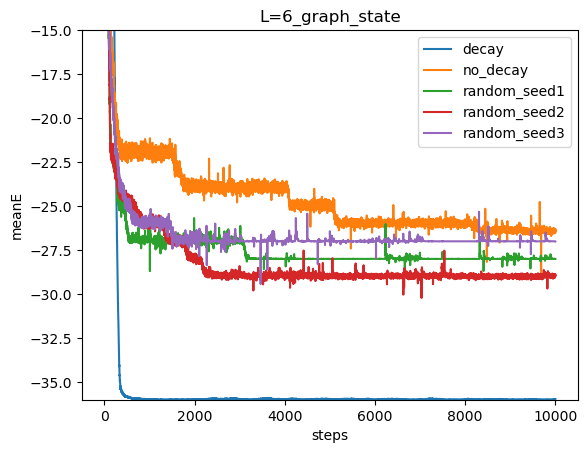

In [8]:
import matplotlib.pyplot as plt
plt.plot(decay_meanE, label="decay")
plt.plot(no_decay_meanE, label="no_decay")
plt.plot(random_meanE_seed1, label="random_seed1")
plt.plot(random_meanE_seed2, label="random_seed2")
plt.plot(random_meanE_seed3, label="random_seed3")
plt.ylim(-36, -15)
plt.legend()
plt.xlabel("steps")
plt.ylabel("meanE")
plt.title("L=6_graph_state")
plt.show()

In [80]:
for i in (1,2,3):
    print(i)

1
2
3


In [83]:
import optax
optax.piecewise_constant_schedule(0.1, boundaries_and_scales=None)

<function optax._src.schedule.piecewise_constant_schedule.<locals>.schedule(count)>

In [84]:
steps = [1000, 2000, 3000]  # Steps at which to change the learning rate
values = [0.01, 0.001, 0.0001]  # Corresponding learning rates

# Step 3: Create a step schedule
lr_schedule = optax.piecewise_constant_schedule(init_value=0.1,  # Initial learning rate
                                                boundaries_and_scales={steps[i]: values[i] for i in range(len(steps))})

In [86]:
lr_schedule(100)

Array(0.1, dtype=float32, weak_type=True)